In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot

# MMD

In [4]:
np.random.seed(2024)

In [5]:
dim = 1
n = 50

x_sample = np.random.multivariate_normal(np.zeros((dim,)), np.eye(dim), n)

y_sample = np.random.multivariate_normal(np.zeros((dim,)), np.eye(dim), n)

In [6]:
kernel = kernels.RBF(sigma_sq=2.)
mmd = metrics.MMD(kernel)
mmd(x_sample, y_sample)

0.028349561648773447

In [7]:
bootstrap = boot.WildBootstrap(mmd, ndraws=5)
pval = bootstrap.pval(x_sample, y_sample)

In [8]:
pval

0.8333333333333334

In [9]:
bootstrap = boot.WildBootstrap(mmd, ndraws=5)
pval = bootstrap.pval(x_sample, y_sample)

In [10]:
pval

1.0

In [11]:
def mmd_experiment_single(kernel_class, Xs, Ys, eps, nboot=500, alpha=0.05):
    res = {
        "deviation": {"val": [], "threshold": [], "rej": []},
        "boot": {"val": [], "threshold": [], "pval": [], "rej": []},
        "robust": {"val": [], "threshold": [], "rej": []},
        "relaxed": {"val": [], "threshold": [], "rej": []},
    }

    for X, Y in tqdm(zip(Xs, Ys), total=Xs.shape[0]):
        kernel = kernel_class(sigma_sq=2.)
        mmd = metrics.MMD(kernel)
        val = mmd(X, Y)
        threshold = mmd.test_threshold(X.shape[0])
        
        # 1. deviation bound
        rej = float(threshold < val)

        # 2. standard bootstrap
        bootstrap = boot.WildBootstrap(mmd, ndraws=nboot)
        pval = bootstrap.pval(X, Y)

        # 3. robust bootstrap
        robust_bstrp = boot.RobustMMDTest(mmd, eps0=eps, ndraws=nboot)
        robust_rej = robust_bstrp.test(0.05, X, Y)
        
        # 4. robust deviation bound
        # thresh_dev_robust = mmd.test_threshold(X.shape[0], method="deviation_robust", eps=eps)
        # rej_dev_robust = float(thresh_dev_robust < val)
        thresh_relaxed = (alpha - eps) / (1 - eps)
        rej_relaxed = float(pval < thresh_relaxed)
        
        # save results
        res["deviation"]["val"].append(val)
        res["deviation"]["threshold"].append(threshold)
        res["deviation"]["rej"].append(rej)
        
        res["boot"]["val"].append(val)
        res["boot"]["threshold"].append(threshold)
        res["boot"]["pval"].append(pval)
        res["boot"]["rej"].append(float(pval < alpha))

        res["robust"]["val"].append(val)
        res["robust"]["threshold"].append(threshold)
        res["robust"]["rej"].append(robust_rej)
        
        res["relaxed"]["val"].append(val)
        res["relaxed"]["threshold"].append(thresh_relaxed)
        res["relaxed"]["rej"].append(rej_relaxed)

    return res

def mmd_experiment(kernel_class, Xs, Ys, eps0, keys, nboot=500):
    """
    Xs: [array(nrep, n, d), ...]
    Ys: [array(nrep, n, d), ...]
    """
    res = {}
    for Xs_i, Ys_i, kk in zip(Xs, Ys, keys):
        res[kk] = mmd_experiment_single(kernel_class, Xs_i, Ys_i, eps0, nboot=nboot)

    return res
    

In [17]:
np.random.seed(2024)

In [18]:
nrep = 20
n = 1000
mean1 = np.zeros((dim,))
mean2 = np.zeros((dim,)) + 0.8

### Gaussian loc
Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))

Ys = np.random.multivariate_normal(mean2, np.eye(dim), (nrep, n))

### Gaussian contam
# Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))

# eps = 0.025 # 0.28
# outlier = 10
# mask = np.random.binomial(1, eps, (nrep, n))
# clean_samples = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
# Ys = np.where(np.expand_dims(mask, -1), np.ones_like(clean_samples) * outlier, clean_samples)

### mixture of Gaussian and t
# Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))

# eps = 0.025
# mask = np.random.binomial(1, eps, (nrep, n))
# norm_rvs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
# t_rvs = 10. + np.expand_dims(np.random.standard_t(df=2, size=(nrep, n)), -1) 
# Ys = np.where(np.expand_dims(mask, -1), t_rvs, norm_rvs)
###

kernel_class = kernels.RBF

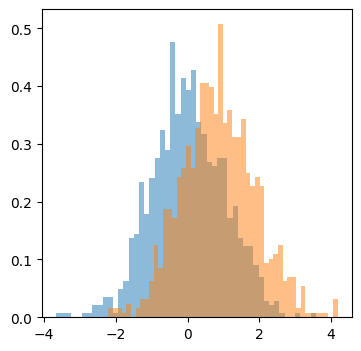

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
_ = ax.hist(Xs[0, :, 0], bins=50, label="X", alpha=0.5, density=True)
_ = ax.hist(Ys[0, :, 0], bins=50, label="Y", alpha=0.5, density=True)

In [20]:
res = mmd_experiment_single(kernel_class, Xs, Ys, eps=eps, nboot=500)

  0%|          | 0/20 [00:00<?, ?it/s]

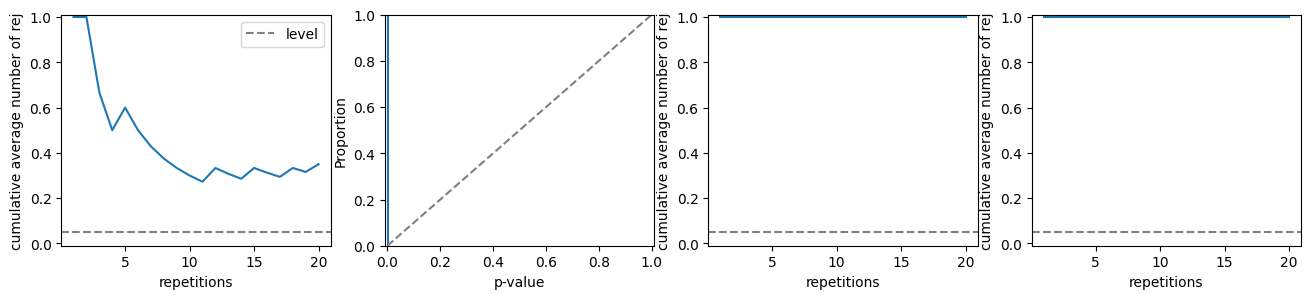

In [21]:
figs, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3))

ax = axes[0]
ma = np.cumsum(res["deviation"]["rej"]) / (np.arange(nrep) + 1.)
ax.plot(np.arange(nrep) + 1., ma)
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.set_ylim(-0.01, 1.01)
ax.set_xlabel("repetitions")
ax.set_ylabel("cumulative average number of rej")
_ = ax.legend()

ax = axes[1]
sns.ecdfplot(ax=ax, x=res["boot"]["pval"])
_ = ax.axline((0., 0.), slope=1., color="grey", linestyle="--")
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(0., 1.)
_ = ax.set_xlabel("p-value")

ax = axes[2]
ma = np.cumsum(res["robust"]["rej"]) / (np.arange(nrep) + 1.)
ax.plot(np.arange(nrep) + 1., ma)
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.set_ylim(-0.01, 1.01)
ax.set_xlabel("repetitions")
ax.set_ylabel("cumulative average number of rej")

if len(res["relaxed"]["rej"]) > 0:
    ax = axes[3]
    ma = np.cumsum(res["relaxed"]["rej"]) / (np.arange(nrep) + 1.)
    ax.plot(np.arange(nrep) + 1., ma)
    ax.axhline(0.05, color="grey", linestyle="--", label="level")
    ax.set_ylim(-0.01, 1.01)
    ax.set_xlabel("repetitions")
    ax.set_ylabel("cumulative average number of rej")


#### Multiple experiments

In [13]:
np.random.seed(2024)

In [14]:
nrep = 100
mean1 = np.zeros((dim,))
# mean2 = np.zeros((dim,)) + 0.8.

eps = 0.025
outlier_ls = [0.1, 1., 10., 100., 1e3, 1e4]

Xs_ls = []
Ys_ls = []

for outlier in outlier_ls:
    ### Gaussian contam
    Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
    
    mask = np.random.binomial(1, eps, (nrep, n))
    clean_samples = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
    Ys = np.where(np.expand_dims(mask, -1), np.ones_like(clean_samples) * outlier, clean_samples)
    ###

    Xs_ls.append(Xs)
    Ys_ls.append(Ys)

kernel_class = kernels.RBF

keys = outlier_ls

In [15]:
res = mmd_experiment(kernel_class, Xs_ls, Ys_ls, eps0=eps, keys=keys, nboot=500)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

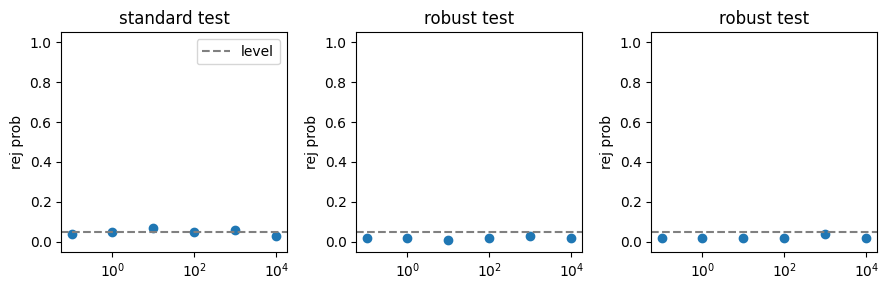

In [16]:
figs, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

ax = axes[0]
rej_prob = [np.mean(res[kk]["boot"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob)
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("")
ax.set_ylabel("rej prob")
ax.set_title("standard test")

ax = axes[1]
rej_prob = [np.mean(res[kk]["robust"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob)
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("")
ax.set_ylabel("rej prob")
ax.set_title("robust test")

ax = axes[2]
rej_prob = [np.mean(res[kk]["relaxed"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob)
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("")
ax.set_ylabel("rej prob")
ax.set_title("robust test")

_ = axes[0].legend()
_ = plt.tight_layout()

In [210]:
np.random.seed(2024)

In [211]:
nrep = 20
mean1 = np.zeros((dim,))
# mean2 = np.zeros((dim,)) + 0.8.

eps = 0.05
outlier_ls = [0.1, 1., 10., 100., 1e3, 1e4]

mmd_res = {"contam": [], "outlier_only": []}

for outlier in outlier_ls:
    ### Gaussian contam
    Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
    
    mask = np.random.binomial(1, eps, (nrep, n))
    clean_samples = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
    Ys = np.where(np.expand_dims(mask, -1), np.ones_like(clean_samples) * outlier, clean_samples)

    Ys_outliers = np.ones_like(Xs) * outlier
    ###

    mmd_contam_ls = []
    mmd_outlier_ls = []
    for (X, Y, Y_o) in tqdm(zip(Xs, Ys, Ys_outliers), total=X.shape[0]):
        kernel = kernel_class(sigma_sq=2.)
        mmd = metrics.MMD(kernel)

        # contaminated data
        val = mmd(X, Y)
        mmd_contam_ls.append(val)

        # outlier only
        val_o = mmd(X, Y_o)
        mmd_outlier_ls.append(val_o)

    mmd_res["contam"].append(mmd_contam_ls)
    mmd_res["outlier_only"].append(mmd_outlier_ls)


  0%|          | 0/6 [00:00<?, ?it/s]

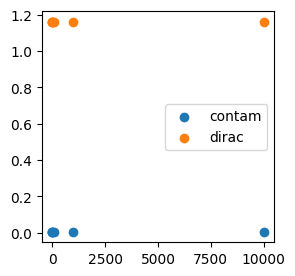

In [213]:
figs, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))

ax = axes
mmd_contam = [np.mean(mmd_res["contam"]) for kk in keys]
mmd_outlier = [np.mean(mmd_res["outlier_only"]) for kk in keys]
ax.scatter(outlier_ls, mmd_contam, label="contam")
ax.scatter(outlier_ls, mmd_outlier, label="dirac")

_ = ax.legend()

# KSD

In [2]:
def ksd_experiment_single(kernel_class, Xs, score_fns, nboot=500, alpha=0.05):
    res = {
        "deviation": {"val": [], "threshold": [], "rej": []},
        "boot": {"val": [], "threshold": [], "pval": [], "rej": [], "boot_stat": []},
        "robust": {"val": [], "threshold": [], "rej": []},
        "relaxed": {"val": [], "threshold": [], "rej": []},
    }

    for X, score_fn in tqdm(zip(Xs, score_fns), total=Xs.shape[0]):
        kernel = kernel_class(sigma_sq=2.)
        ksd = metrics.KSD(kernel, score_fn=score_fn)
        val = ksd(X, X, vstat="vstat")

        # 1. bootstrap
        bootstrap = boot.WildBootstrap(ksd, ndraws=nboot)
        pval, boot_stat = bootstrap.pval(X, X, return_boot=True)

        # save results
        res["boot"]["val"].append(val)
        res["boot"]["pval"].append(pval)
        res["boot"]["rej"].append(float(pval < alpha))
        res["boot"]["boot_stat"].append(boot_stat)

        # # 2. Efron's bootstrap
        # bootstrap = boot.EfronBootstrap(ksd, ndraws=nboot)
        # pval, boot_stat = bootstrap.pval(X, return_boot=True)

        # # save results
        # res["boot"]["val"].append(val)
        # res["boot"]["pval"].append(pval)
        # res["boot"]["rej"].append(float(pval < alpha))
        # res["boot"]["boot_stat"].append(boot_stat)

    return res

def ksd_experiment(kernel_class, Xs, score_fns, keys, nboot=500):
    """
    Xs: [array(nrep, n, d), ...]
    Ys: [array(nrep, n, d), ...]
    """
    res = {}
    for Xs_i, score_fn_i, kk in zip(Xs, score_fns, keys):
        res[kk] = ksd_experiment_single(kernel_class, Xs_i, score_fn_i, nboot=nboot)

    return res

def prop_larger(t, ls):
    return np.mean(np.array(ls) > t)

In [3]:
np.random.seed(2024)

In [4]:
nrep = 10
n = 1000
dim = 1
mean1 = np.zeros((dim,)) # data
mean2 = np.zeros((dim,)) # model

### Gaussian loc
# Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))

# score_fns = [lambda x: - (x - mean2) for _ in range(nrep)]

# eps = 0.
### Gaussian with outliers
score_fns = [lambda x: - (x - mean2) for _ in range(nrep)]

eps = 0.01
outlier = 10.
Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
n_outlier = max(1, int(n * eps))
Xs[:, :n_outlier] = outlier
###

kernel_class = kernels.RBF

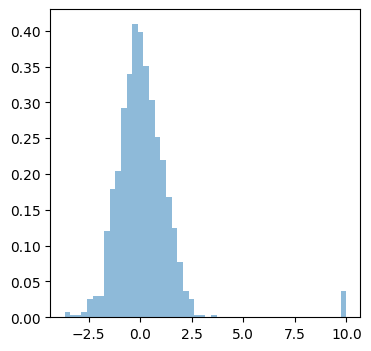

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
_ = ax.hist(Xs[0, :, 0], bins=50, label="X", alpha=0.5, density=True)
# _ = ax.hist(Ys[0, :, 0], bins=50, label="Y", alpha=0.5, density=True)

In [6]:
res = ksd_experiment_single(kernel_class, Xs, score_fns, nboot=1000)

  0%|          | 0/10 [00:00<?, ?it/s]

one-sample



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.09it/s]


one-sample



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.70it/s]


one-sample



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.97it/s]


one-sample



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.86it/s]


one-sample



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.65it/s]


one-sample



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.48it/s]


one-sample



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.20it/s]


one-sample



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.98it/s]


one-sample



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.34it/s]


one-sample



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.81it/s]


In [7]:
# get test statistic and bootstrap stats
boot_stat = res["boot"]["boot_stat"][0]
stat = res["boot"]["val"][0]

In [12]:
np.random.seed(2024)

In [13]:
# simulate sampling distribution for stat
stat_ls = []
Xs = np.random.multivariate_normal(mean1, np.eye(dim), (1000, n))
score_fn = score_fns[0]

kernel = kernels.RBF(sigma_sq=2.)
ksd = metrics.KSD(kernel, score_fn=score_fn)
for X in tqdm(Xs):
    stat_ls.append(ksd(X, X, vstat=True))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
np.random.seed(2024)
efron_bootstrap = boot.EfronBootstrap(ksd, ndraws=1000)
efron_boot_stats, efron_test_stat = efron_bootstrap.compute_bootstrap(Xs[0])

one-sample


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.19it/s]


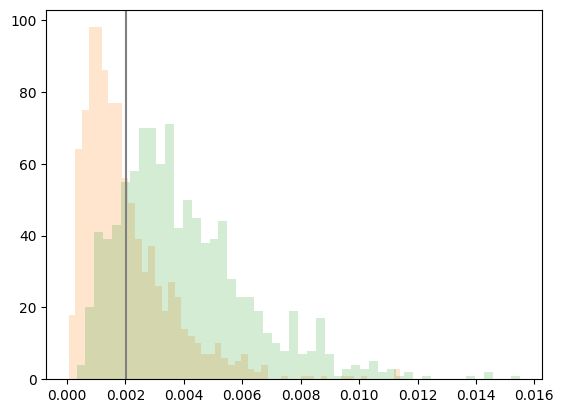

In [15]:
_ = plt.hist(stat_ls, bins=50, alpha=0.2, color="C1")
_ = plt.hist(efron_boot_stats, bins=50, alpha=0.2, color="C2")

plt.axvline(efron_test_stat, color="grey")

In [82]:
t = np.percentile(efron_boot_stats, 95)
prop_larger(t, efron_boot_stats), prop_larger(t, stat_ls)

(0.05, 0.007)

In [27]:
xx = Xs[:3]
rr = []
for xxx in xx:
    rr.append(ksd(xxx, xxx, vstat=True))
rr

[0.0020215138269906057, 0.0025863062444021804, 0.0017635422209850654]

In [28]:
ksd(xx, xx, vstat=True)

array([0.00202151, 0.00258631, 0.00176354])

In [138]:
np.random.seed(2024)
efron_bootstrap.ndraws = 5
efron_bootstrap.compute_bootstrap(xx[0])

one-sample


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.12it/s]


(array([0.00451231, 0.00285355, 0.00267437, 0.00267581, 0.00869919]),
 0.0020215138269906057)

In [94]:
np.random.seed(2024)
efron_bootstrap.compute_bootstrap(xx[0])

one-sample


(array([0.00451231, 0.00285355, 0.00267437, 0.00267581, 0.00869919]),
 0.0020215138269906057)

In [45]:
ii = [0, 1, 0]
AA = np.eye(3)
AA[ii]

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [46]:
np.reshape(AA, (-1,))

array([1., 0., 0., 0., 1., 0., 0., 0., 1.])

In [47]:
ii_conv = np.array([[i1, i2] for i2 in ii for i1 in ii])

In [49]:
np.reshape(AA[ii_conv[:, 0], ii_conv[:, 1]], AA.shape)

array([[1., 0., 1.],
       [0., 1., 0.],
       [1., 0., 1.]])

In [61]:
ii1, ii2 = np.meshgrid(ii, ii)
AA[ii1, ii2]

array([[1., 0., 1.],
       [0., 1., 0.],
       [1., 0., 1.]])

In [73]:
iib1 = np.repeat(ii1[np.newaxis], 2, 0)
iib2 = np.repeat(ii2[np.newaxis], 2, 0)
iib1.shape

(2, 3, 3)

In [75]:
AA[iib1, iib2]

array([[[1., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.]],

       [[1., 0., 1.],
        [0., 1., 0.],
        [1., 0., 1.]]])

In [98]:
vv = ksd.vstat(xx[0], xx[0])
vv

(1000, 1000)

In [131]:
def ff(jj):
    return vv[iib1[jj], iib2[jj]]

ff_vec = np.vectorize(ff)
# ff_vec(np.arange(0, iib1.shape[0], 1))
# ff_vec(np.array([0, 1], np.int64))

[array([[3.78238187, 0.32264409, 3.78238187],
        [0.32264409, 1.54368167, 0.32264409],
        [3.78238187, 0.32264409, 3.78238187]]),
 array([[3.78238187, 0.32264409, 3.78238187],
        [0.32264409, 1.54368167, 0.32264409],
        [3.78238187, 0.32264409, 3.78238187]])]

In [127]:
np.arange(0, iib1.shape[0])

array([0, 1])

In [116]:
iib1.shape

(2, 3, 3)

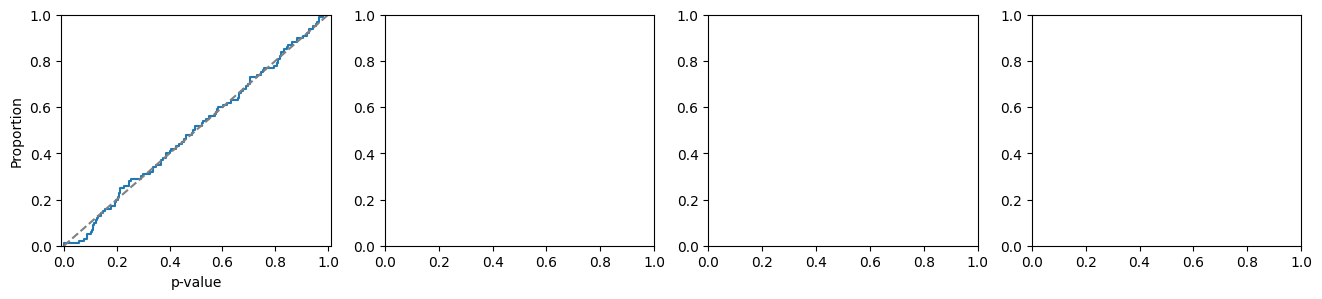

In [37]:
figs, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3))

ax = axes[0]
sns.ecdfplot(ax=ax, x=res["boot"]["pval"])
_ = ax.axline((0., 0.), slope=1., color="grey", linestyle="--")
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(0., 1.)
_ = ax.set_xlabel("p-value")


Simulating test statistic with increasing outlier vals (non-robustness of KSD)

In [81]:
np.random.seed(2024)

In [82]:
# simulate sampling distribution for stat
stats_ls_all_ol = []
outliers_ls = [0.001, 0.01, 0.1, 1., 10., 100.]

for outlier in outliers_ls:
    stat_ls = []
    
    ###
    mean1 = np.zeros((dim,)) # data
    mean2 = np.zeros((dim,)) # model
    
    eps = 0.01
    Xs = np.random.multivariate_normal(mean1, np.eye(dim), (1000, n))
    n_outlier = max(1, int(n * eps))
    Xs[:, :n_outlier] = outlier

    score_fn = lambda x: - (x - mean2)
    ###
    
    kernel = kernels.RBF(sigma_sq=2.)
    ksd = metrics.KSD(kernel, score_fn=score_fn)
    for X in tqdm(Xs):
        stat_ls.append(ksd(X, X))

    stats_ls_all_ol.append(stat_ls)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [64]:
# # stats_ls_all2 = stats_ls_all

# stats_ls_all3 = stats_ls_all

# outliers_ls = [0.001, 0.01, 0.1, 1., 10., 100.]
# stats_ls_all = stats_ls_all + stats_ls_all2

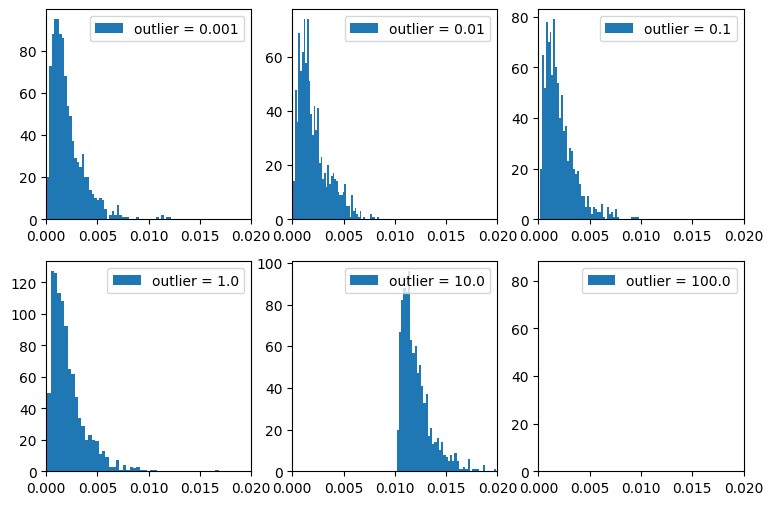

In [75]:
# true sampling distribution
figs, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))

for i, ww in enumerate(outliers_ls):
    ax = axes.flatten()[i]
    ax.hist(stats_ls_all_ol[i], bins=50, label=f"outlier = {ww}")
    ax.set_xlim(0., 0.02)
    ax.legend()

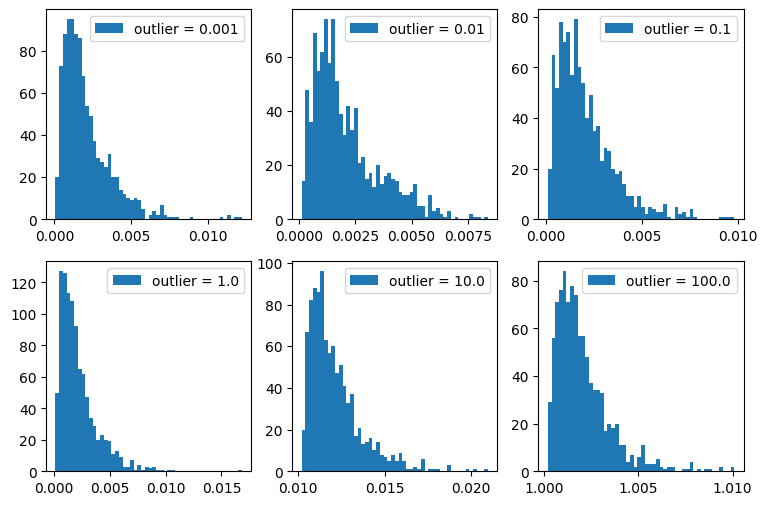

In [65]:
# true sampling distribution
figs, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))

for i, ww in enumerate(outliers_ls):
    ax = axes.flatten()[i]
    ax.hist(stats_ls_all_ol[i], bins=50, label=f"outlier = {ww}")
    ax.legend()

Simulating test statistic with increasing contam levels (non-robustness of KSD)

In [66]:
np.random.seed(2024)

In [67]:
# simulate sampling distribution for stat
stats_ls_all_eps = []
eps_ls = [0.001, 0.005, 0.01, 0.05, 0.1]

for eps in eps_ls:
    stat_ls = []
    
    ###
    mean1 = np.zeros((dim,)) # data
    mean2 = np.zeros((dim,)) # model
    
    Xs = np.random.multivariate_normal(mean1, np.eye(dim), (1000, n))
    n_outlier = max(1, int(n * eps))
    Xs[:, :n_outlier] = outlier

    score_fn = lambda x: - (x - mean2)
    ###
    
    kernel = kernels.RBF(sigma_sq=2.)
    ksd = metrics.KSD(kernel, score_fn=score_fn)
    for X in tqdm(Xs):
        stat_ls.append(ksd(X, X, vstat=True))

    stats_ls_all_eps.append(stat_ls)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

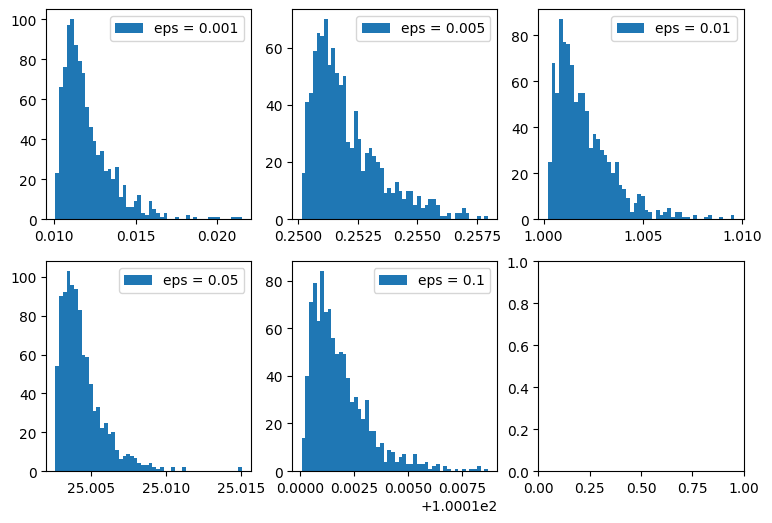

In [71]:
# true sampling distribution
figs, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))

for i, ww in enumerate(eps_ls):
    ax = axes.flatten()[i]
    ax.hist(stats_ls_all_eps[i], bins=50, label=f"eps = {ww}")
    ax.legend()

#### Multiple experiments

In [7]:
np.random.seed(2024)

In [8]:
nrep = 2
mean1 = np.zeros((dim,))

# eps = 0.01
# eps_list = [0.001, 0.005, 0.01]
eps_list = [0.001, 0.0025, 0.005, 0.01]
outlier_ls = [0.1, 1., 10., 100., 1e3, 1e4]

res = {}

for eps in eps_list:
    print(f"eps: {eps}")
    
    Xs_ls = []
    score_fns_ls = []
    
    for outlier in outlier_ls:
        ### Gaussian contam
        # outliers = np.random.multivariate_normal(mean1 + outlier, np.eye(dim), (nrep, n))
        # clean_samples = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
        # mask = np.random.binomial(1, eps, (nrep, n))
        # Xs = np.where(np.expand_dims(mask, -1), outliers, clean_samples)

        Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
        n_outlier = max(1, int(n * eps))
        Xs[:, :n_outlier] = outlier
    
        score_fns = [lambda x: - (x - mean1) for _ in range(nrep)]
        ###
    
        Xs_ls.append(Xs)
        score_fns_ls.append(score_fns)
    
    kernel_class = kernels.RBF
    
    keys = outlier_ls
    
    res_sub = ksd_experiment(kernel_class, Xs_ls, score_fns_ls, keys=keys, nboot=500)
    res[eps] = res_sub

eps: 0.001


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

eps: 0.0025


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

eps: 0.005


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

eps: 0.01


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

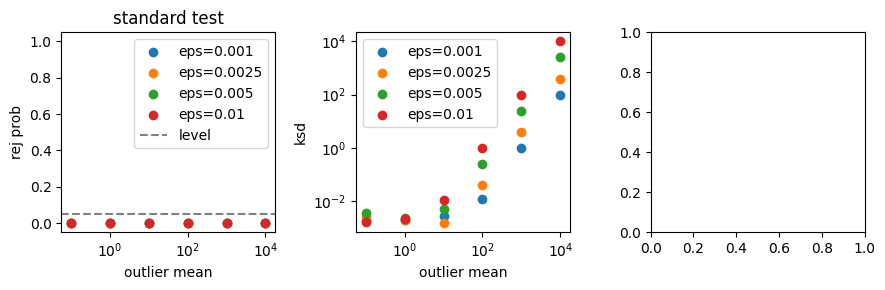

In [21]:
figs, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

ax = axes[0]
for eps in eps_list:
    r = res[eps]
    rej_prob = [np.mean(r[kk]["boot"]["rej"]) for kk in keys]
    ax.scatter(keys, rej_prob, label=f"eps={eps}")

ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("outlier mean")
ax.set_ylabel("rej prob")
ax.set_title("standard test")
ax.legend()

ax = axes[1]
# for eps in eps_list[:1]:
for eps in eps_list:
    r = res[eps]
    rej_prob = [np.mean(r[kk]["boot"]["val"]) for kk in keys]
    ax.scatter(keys, rej_prob, label=f"eps={eps}")
ax.set_ylabel("ksd")
ax.set_xlabel("outlier mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

_ = plt.tight_layout()

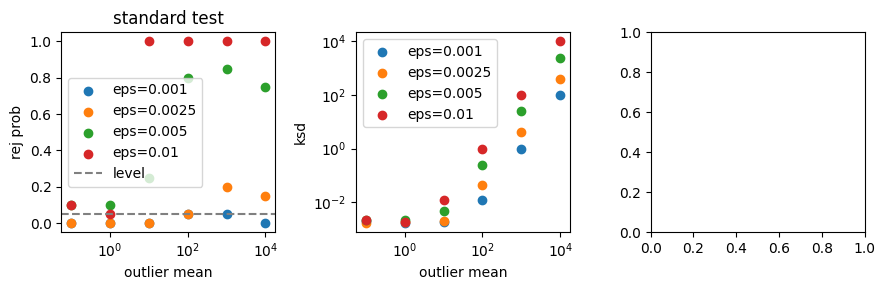

In [16]:
figs, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

ax = axes[0]
for eps in eps_list:
    r = res[eps]
    rej_prob = [np.mean(r[kk]["boot"]["rej"]) for kk in keys]
    ax.scatter(keys, rej_prob, label=f"eps={eps}")

ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("outlier mean")
ax.set_ylabel("rej prob")
ax.set_title("standard test")
ax.legend()

ax = axes[1]
# for eps in eps_list[:1]:
for eps in eps_list:
    r = res[eps]
    rej_prob = [np.mean(r[kk]["boot"]["val"]) for kk in keys]
    ax.scatter(keys, rej_prob, label=f"eps={eps}")
ax.set_ylabel("ksd")
ax.set_xlabel("outlier mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

_ = plt.tight_layout()

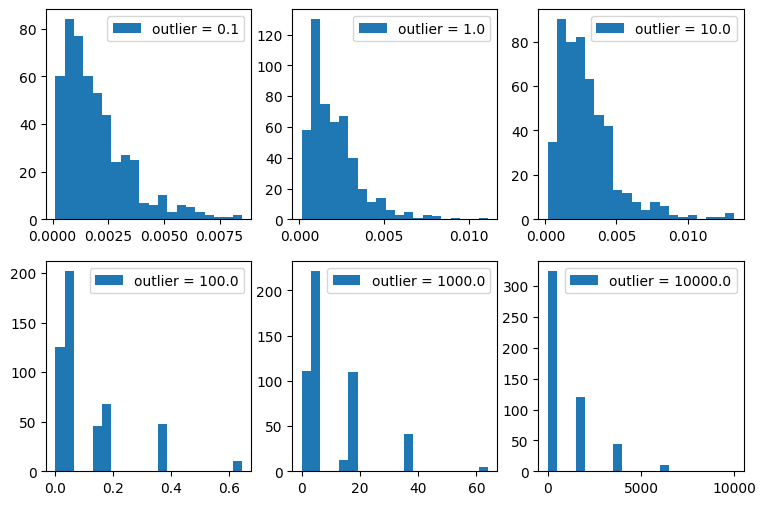

In [23]:
# check bootstrap distributions as a func of outliers
figs, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
eps = 0.01
r = res[eps]
bb_stats = [r[kk]["boot"]["boot_stat"][0] for kk in keys]

for i, ww in enumerate(outlier_ls):
    ax = axes.flatten()[i]
    ax.hist(bb_stats[i], bins=20, label=f"outlier = {ww}")
    ax.legend()

 Gaussian loc model (to check the power)

In [56]:
np.random.seed(2024)

In [ ]:
nrep = 50

n_ls = [50, 100, 500, 1000]
offset_ls = [1e-1, 1., 10., 100.]

res = {}

for n in n_ls:
    print(f"key: {n}")
    
    Xs_ls = []
    score_fns_ls = []
    
    for c in offset_ls:
        ### Gaussian loc
        mean1 = np.zeros((dim,)) + c # data
        mean2 = np.zeros((dim,)) # model

        Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))

        score_fns = [lambda x: - (x - mean2) for _ in range(nrep)]
        ###

        Xs_ls.append(Xs)
        score_fns_ls.append(score_fns)
    
    kernel_class = kernels.RBF
    
    keys = offset_ls
    
    res_sub = ksd_experiment(kernel_class, Xs_ls, score_fns_ls, keys=keys, nboot=500)
    res[n] = res_sub

key: 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

key: 100


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

key: 500


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

key: 1000


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

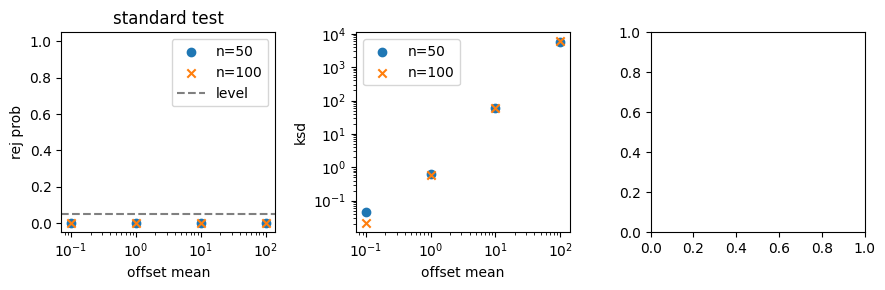

In [55]:
markers = ["o", "x", "+", ">", "D"]

figs, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

ax = axes[0]
for i, k in enumerate(n_ls):
    r = res[k]
    rej_prob = [np.mean(r[kk]["boot"]["rej"]) for kk in keys]
    ax.scatter(keys, rej_prob, label=f"n={k}", marker=markers[i])

ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("offset mean")
ax.set_ylabel("rej prob")
ax.set_title("standard test")
ax.legend()

ax = axes[1]
# for eps in eps_list[:1]:
for i, k in enumerate(n_ls):
    r = res[k]
    rej_prob = [np.mean(r[kk]["boot"]["val"]) for kk in keys]
    ax.scatter(keys, rej_prob, label=f"n={k}", marker=markers[i])
ax.set_ylabel("ksd")
ax.set_xlabel("offset mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

_ = plt.tight_layout()

# Score functions of contaminated distributions

In [92]:
import jax.numpy as jnp
import jax

In [100]:
eps = 0.01
noise_mu = 3.

def log_q(x):
    """Assume unit var
    """
    val = jnp.log((1 - eps) * jnp.exp(- 0.5 * x**2) + eps * jnp.exp(- 0.5 * (x - noise_mu)**2))
    return val

def log_p(x):
    val = - 0.5 * x**2
    return val

def log_r(x):
    """Assume unit var
    """
    val = - 0.5 * (x - noise_mu)**2
    return val

score_q_fn = jax.vmap(jax.grad(log_q))
score_p_fn = jax.vmap(jax.grad(log_p))

In [101]:
xx = jnp.reshape(jnp.linspace(-10., 10., 1001), (-1,))

s_q = score_q_fn(xx)
s_p = score_p_fn(xx)

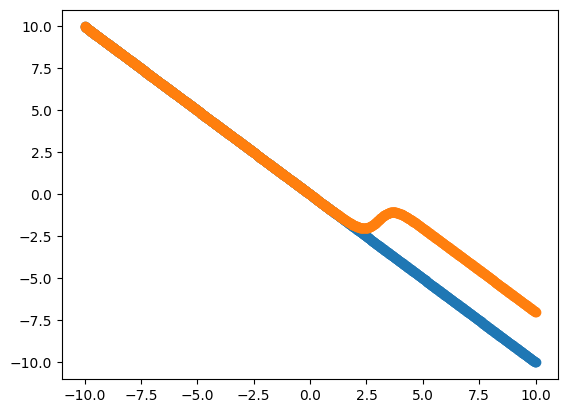

In [102]:
plt.scatter(xx, s_p, label="s_p")
plt.scatter(xx, s_q, label="s_q")

In [103]:
def score_diff(log_r, log_p, eps, xx):
    score_r_fn = jax.vmap(jax.grad(log_r))
    score_p_fn = jax.vmap(jax.grad(log_p))
    
    s_r = score_r_fn(xx)
    s_p = score_p_fn(xx)
    sr_minus_sp = s_r - s_p

    prob_r = np.exp(log_r(xx))
    prob_p = np.exp(log_p(xx))

    sq_minus_sp = eps * prob_r / (eps * prob_r + (1 - eps) * prob_p) * sr_minus_sp
    return sq_minus_sp

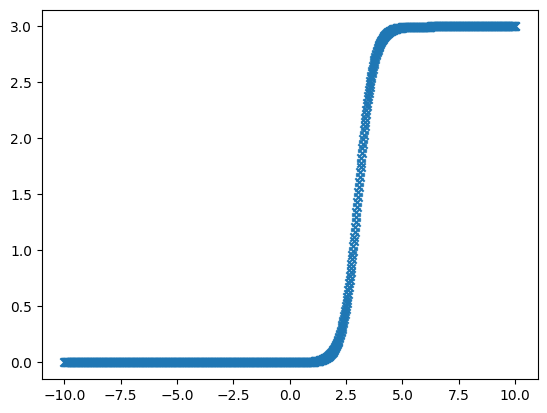

In [112]:
# plt.scatter(xx, score_diff(log_r, log_p, eps=eps, xx=xx))
plt.scatter(xx, s_q - s_p, label="(s_q - s_p)*m", marker="x")

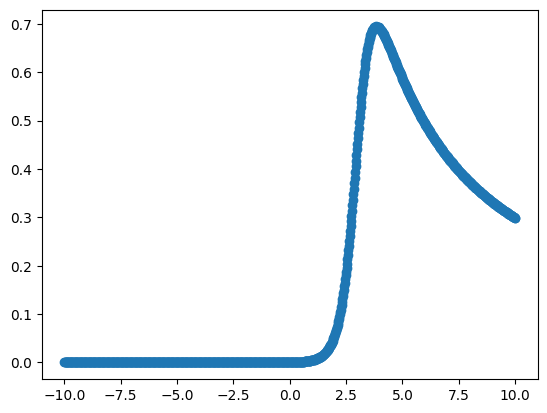

In [105]:
mm = kernels.PolyWeightFunction()(np.reshape(xx, (-1, 1)))
# plt.scatter(xx, s_q - s_p, label="(s_q - s_p)*m")
plt.scatter(xx, (s_q - s_p) * mm, label="(s_q - s_p)*m")